This Jupyter notebook shows performance of the sharing capability of a commodity in d3ploy. in this case the commodity is power.

# Case 7

Flow: Source -(sourceout)-> Reactor -(reactorout)-> Sink

The driving commodity is 'Power' with a demand equation of 100*t.

The next cell produces .xml input file of Cyclus, its respective .sqlite output, and post processing data of that output file used in the following cells.

In [18]:
import json
import re
import subprocess
import os
import sqlite3 as lite
import copy
import glob
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import d3ploy.tester as tester
import d3ploy.plotter as plotter
import collections

# Delete previously generated files
direc = os.listdir('./')
hit_list = glob.glob('*.sqlite') + glob.glob('*.xml') + glob.glob('*.png') + glob.glob('*.csv') + glob.glob('*.txt')
for file in hit_list:
    os.remove(file)

ENV = dict(os.environ)
ENV['PYTHONPATH'] = ".:" + ENV.get('PYTHONPATH', '')

calc_methods = ["ma"]
#calc_methods = ["ma", "arma", "arch", "poly", "exp_smoothing", "holt_winters", "fft"]

demand_eq = "100*t"

control = """
<control>
    <duration>40</duration>
    <startmonth>1</startmonth>
    <startyear>2000</startyear>
</control>"""

archetypes = """
<archetypes>
        <spec>
            <lib>cycamore</lib>
            <name>Source</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Reactor</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Sink</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullRegion</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullInst</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>DeployInst</name>
        </spec>
        <spec>
            <lib>d3ploy.demand_driven_deployment_inst</lib>
            <name>DemandDrivenDeploymentInst</name>
        </spec>
    </archetypes>
"""

source = """
<facility>
    <name>source</name>
    <config>
        <Source>
            <outcommod>sourceout</outcommod>
            <outrecipe>sourceoutrecipe</outrecipe>
            <throughput>3000</throughput>
        </Source>
    </config>
</facility>
"""

reactor1 = """
<facility>
    <name>reactor1</name>
    <config>
      <Reactor>
        <fuel_inrecipes>
            <val>sourceoutrecipe</val>
        </fuel_inrecipes>
        <fuel_outrecipes>
            <val>reactoroutrecipe</val>
        </fuel_outrecipes>
        <fuel_incommods>
            <val>sourceout</val>
        </fuel_incommods>
        <fuel_outcommods>
            <val>reactorout</val>
        </fuel_outcommods>
        <cycle_time>1</cycle_time>
        <refuel_time>0</refuel_time>
        <assem_size>100</assem_size>
        <n_assem_core>3</n_assem_core>
        <n_assem_batch>1</n_assem_batch>
        <power_cap>20</power_cap>
      </Reactor>
    </config>
</facility>
"""

reactor2 = """
<facility>
    <name>reactor2</name>
    <config>
      <Reactor>
        <fuel_inrecipes>
            <val>sourceoutrecipe</val>
        </fuel_inrecipes>
        <fuel_outrecipes>
            <val>reactoroutrecipe</val>
        </fuel_outrecipes>
        <fuel_incommods>
            <val>sourceout</val>
        </fuel_incommods>
        <fuel_outcommods>
            <val>reactorout</val>
        </fuel_outcommods>
        <cycle_time>1</cycle_time>
        <refuel_time>0</refuel_time>
        <assem_size>100</assem_size>
        <n_assem_core>3</n_assem_core>
        <n_assem_batch>1</n_assem_batch>
        <power_cap>30</power_cap>
      </Reactor>
    </config>
</facility>
"""

sink = """
<facility>
        <name>sink</name>
        <config>
            <Sink>
                <in_commods>
                    <val>reactorout</val>
                </in_commods>
                <max_inv_size>1e6</max_inv_size>
            </Sink>
        </config>
    </facility>
"""

region = {}

for calc_method in calc_methods:
    region[calc_method] = """
    <region>
        <config>
            <NullRegion>
            </NullRegion>
        </config>

        <institution>
          <config>
            <NullInst/>
          </config>
          <initialfacilitylist>
            <entry>
              <number>1</number>
              <prototype>sink</prototype>
            </entry>              
          </initialfacilitylist>
          <name>sink_source_facilities</name>
        </institution>

        <institution>
            <config>
                <DemandDrivenDeploymentInst>
                    <driving_commod>POWER</driving_commod>
                    <calc_method>%s</calc_method>
                    <demand_eq>%s</demand_eq>
                    <record>1</record>
                    <steps>1</steps>
                    <share>Power</share>
                    <facility_commod>
                        <item>
                            <facility>source</facility>
                            <commod>sourceout</commod>
                        </item>
                        <item>
                            <facility>reactor1</facility>
                            <commod>POWER</commod>
                        </item>
                        <item>
                            <facility>reactor2</facility>
                            <commod>POWER</commod>
                        </item>
                    </facility_commod>
                    <facility_capacity>
                        <item>
                            <facility>source</facility>
                            <capacity>3000</capacity>
                        </item>
                        <item>
                            <facility>reactor1</facility>
                            <capacity>20</capacity>
                        </item>
                        <item>
                            <facility>reactor2</facility>
                            <capacity>30</capacity>
                        </item>
                    </facility_capacity>
                    <facility_sharing>
                        <item>
                            <facility>reactor1</facility>
                            <percentage>60</percentage>
                        </item>
                        <item>
                            <facility>reactor2</facility>
                            <percentage>40</percentage>
                        </item>
                    </facility_sharing>
                </DemandDrivenDeploymentInst>
            </config>
            <name>source_inst</name>
            </institution>

        <name>SingleRegion</name>
    </region>
    """%(calc_method, demand_eq)

recipe = """
<recipe>
   <name>sourceoutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
   <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
</recipe>
 
<recipe>
   <name>reactoroutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>Kr85</id> <comp>50</comp> </nuclide>
   <nuclide> <id>Cs137</id> <comp>50</comp> </nuclide>
</recipe>
 """

metric_dict = {}
for calc_method in calc_methods:
    input_file = 'case7_'+ calc_method +'.xml'
    output_file = 'case7_'+ calc_method +'.sqlite'
    name = 'case7_'+ calc_method +'_power'

    with open(input_file, 'w') as f:
        f.write('<simulation>\n')
        f.write(control + archetypes)
        f.write(source + reactor1 + reactor2 + sink)
        f.write(region[calc_method])
        f.write(recipe)
        f.write('</simulation>')

    s = subprocess.check_output(['cyclus', '-o', output_file, input_file],
                            universal_newlines=True, env=ENV)

    agent_entry_dict = {}
    commod_dict = { 'power': ['reactor1', 'reactor2']}
    for commod, facility in commod_dict.items():
        agent_entry_dict[commod] = tester.get_agent_dict(output_file, facility)
    all_dict_power = {}
    all_dict_power = tester.supply_demand_dict_driving(output_file, demand_eq, 'power')
    plotter.plot_demand_supply_agent(all_dict_power, agent_entry_dict['power'],
                                     'power', name, True, True, False, 1)
    

CalledProcessError: Command '['cyclus', '-o', 'case7_ma.sqlite', 'case7_ma.xml']' returned non-zero exit status 1.

The next cells prints the images of the variables 'Demand', 'Calculated Demand', 'Supply', and 'Calculated Supply' for the different NO methods. This allows to see what the last table displays, which is how well each algorithm works for this case study for each time step.

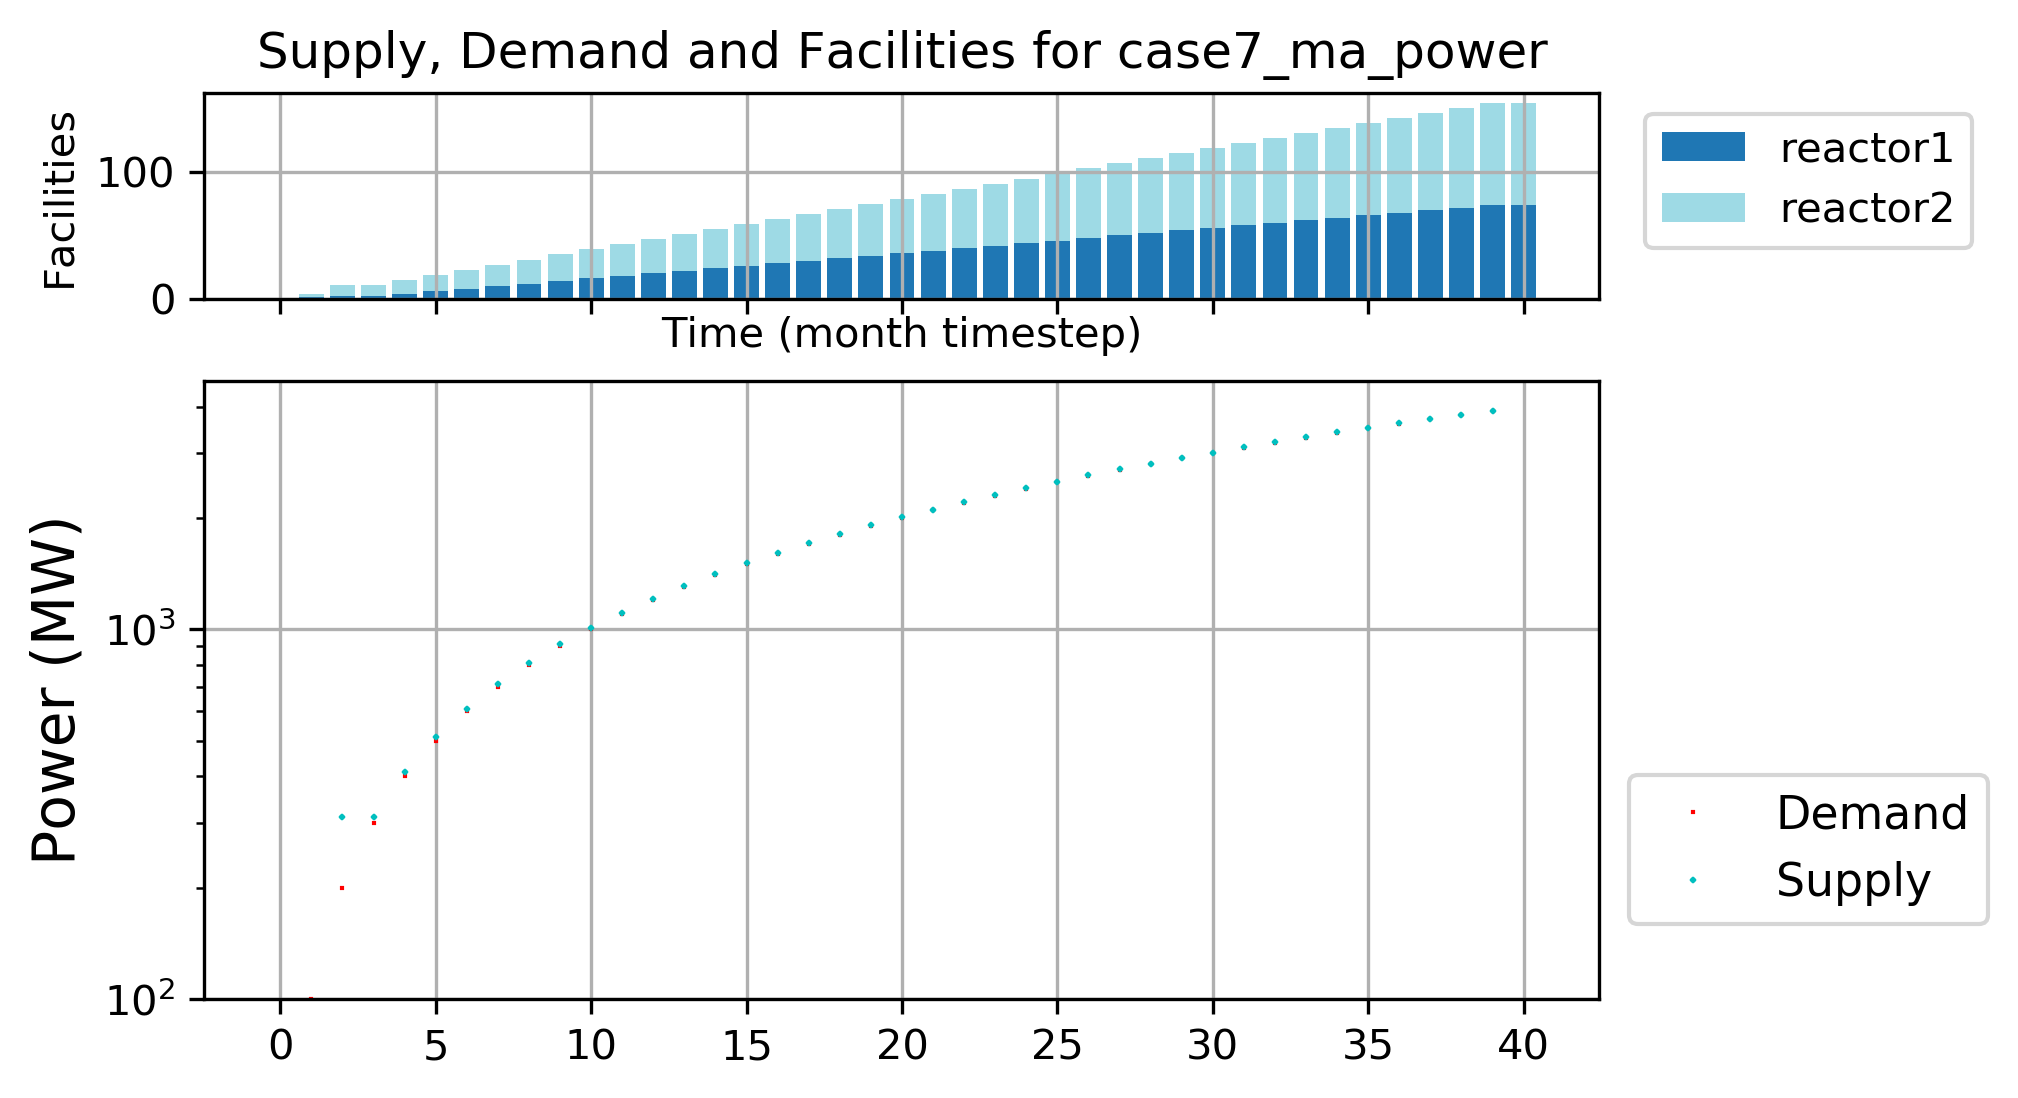

In [14]:
from IPython.display import Image
from IPython.display import display

I1 = Image(filename='case7_ma_power.png')
display(I1)
